In [193]:
import tabula
import pandas as pd
import altair as alt

import geopandas as gpd
#pd.set_option('display.max_columns', None)

## prep
* shapes bezirek
* shapes ringbahn

## aufbereitung und viz von ...
* Öffentlicher Stellplatz
* PKW Besitz je Bezirk
* Anzahl Fahrzeuge bei KBA (1.234.645) *0,5 - > ~7Mio qm entspricht 2x Tempelhofer Feld (2x355ha) (https://www.kba.de/DE/Presse/Pressemitteilungen/2021/Fahrzeugbestand/pm08_fz_bestand_pm_komplett.html)

* Einkommen und PKW-besitz
* Fakor wiviele Pkws haben ober 20% mehr als untere 20%

# geo prep

In [386]:
def Comma2Point(df,cols):
    for c in cols:
        try:
            if "%"  in df[c][0]:
                df[c]=df[c].str.replace(',','.').str.replace('%','').astype(float)
                df[c]=df[c]/100
            else:
                df[c]=df[c].str.replace(',','.').astype(float)
        except:
            print ('bla')
            
    return df


###  Bezirke

In [262]:
bezirke_layer=gpd.read_file(r"..\\berlin_vzaehlung\\shapes\\BerlinerBezirke.geojson")

bezirke_layer=bezirke_layer[['name','geometry']].copy()
bezirke_layer=bezirke_layer[bezirke_layer.name.notnull()].copy()
bezirke_layer.geometry=bezirke_layer.buffer(0.00001)
bezirke_layer.name=bezirke_layer.name.str.replace('ö','oe')

C:\Users\simon\AppData\Local\Temp/ipykernel_19964/226119780.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bezirke_layer.geometry=bezirke_layer.buffer(0.00001)


In [263]:
import topojson
#krs.geometry= krs.buffer(0) #falls repair geometry notwendig\n",
bezirke_layer_tj = topojson.Topology(bezirke_layer, prequantize=False, topology=True)
bezirke_layer_tj_sim = bezirke_layer_tj.toposimplify(0.002)
bezirke_layer = bezirke_layer_tj_sim.to_gdf()
bezirke_layer.crs='epsg:4326'

In [264]:
bezirke_layer_cent=bezirke_layer.copy()
bezirke_layer_cent.geometry =bezirke_layer_cent.centroid

bezirke_layer_cent['x']=bezirke_layer_cent.geometry.x
bezirke_layer_cent['y']=bezirke_layer_cent.geometry.y

C:\Users\simon\AppData\Local\Temp/ipykernel_19964/2648236161.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bezirke_layer_cent.geometry =bezirke_layer_cent.centroid


<AxesSubplot:>

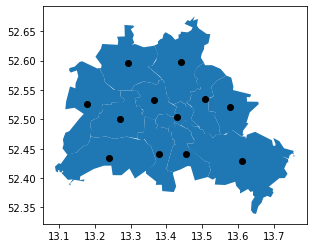

In [265]:
ax=bezirke_layer.plot()
bezirke_layer_cent.plot(ax=ax, color='black')

### Hundekopf

In [266]:
# https://overpass-turbo.eu/s/1adC
hundekopf=gpd.read_file(r"..\\srv\Berlin\hundekopf.geojson")

In [267]:
hundekopf_buff=hundekopf.copy()
hundekopf_buff.geometry= hundekopf_buff.buffer(0.0001)#.dissolve() continents = world.dissolve(by='continent', aggfunc='sum')

C:\Users\simon\AppData\Local\Temp/ipykernel_19964/968948167.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hundekopf_buff.geometry= hundekopf_buff.buffer(0.0001)#.dissolve() continents = world.dissolve(by='continent', aggfunc='sum')


In [268]:
hundekopf_diss=hundekopf_buff.dissolve() #.plot()

# Öffentlicher Stellplatz

In [269]:
import glob
files=glob.glob('Berlin_Tabellen_*.pdf')

In [270]:
df_all = pd.DataFrame()

for file in files:
    #print (file)
    bezirk=file.split('_')[-1].replace('.pdf','')
    
    #df = tabula.read_pdf(file, pages='44')
    df= tabula.read_pdf(file, 
                       pages='36',
                      area=[ [41, 0, 55, 100]],
                       relative_area=True,)
    df=df[0]
    df =df[['Üblicherweise genutzter Abstellort','Gesamt']]
    df['Bezirk']=bezirk
    
    df_all=df_all.append(df)

In [271]:
df_all.head()

,Üblicherweise genutzter Abstellort,Gesamt,Bezirk
0,Garage/Carport/privater Stellplatz,"38,0 %",Charlottenburg-Wilmersdorf
1,Öffentlicher Straßenraum,"58,8 %",Charlottenburg-Wilmersdorf
2,Unterschiedlich,"3,2 %",Charlottenburg-Wilmersdorf
3,Summe,100 %,Charlottenburg-Wilmersdorf
0,Garage/Carport/privater Stellplatz,"26,8 %",Friedrichshain-Kreuzberg


In [272]:
df_all[df_all['Üblicherweise genutzter Abstellort']=='Öffentlicher Straßenraum']

,Üblicherweise genutzter Abstellort,Gesamt,Bezirk
1,Öffentlicher Straßenraum,"58,8 %",Charlottenburg-Wilmersdorf
1,Öffentlicher Straßenraum,"71,0 %",Friedrichshain-Kreuzberg
1,Öffentlicher Straßenraum,"56,8 %",Lichtenberg
1,Öffentlicher Straßenraum,"46,0 %",Marzahn-Hellersdorf
1,Öffentlicher Straßenraum,"62,9 %",Mitte
1,Öffentlicher Straßenraum,"46,6 %",Neukoelln
1,Öffentlicher Straßenraum,"56,6 %",Pankow
1,Öffentlicher Straßenraum,"36,8 %",Reinickendorf
1,Öffentlicher Straßenraum,"37,3 %",Spandau
1,Öffentlicher Straßenraum,"48,2 %",Steglitz-Zehlendorf


In [273]:
df_all['Gesamt']=df_all['Gesamt'].str.replace(' %','').str.replace(',','.').astype(float)/100

In [274]:
source= df_all[df_all['Üblicherweise genutzter Abstellort']=='Öffentlicher Straßenraum']

order=list(source.sort_values('Gesamt', ascending=False)['Bezirk'])

bar=alt.Chart(source,title='').mark_bar().encode(
    #x='Gesamt:Q',
    x=alt.X('Gesamt:Q',axis=alt.Axis(format='%', title='')),
   # y="Bezirk:O",
    y=alt.Y('Bezirk:O', scale=alt.Scale(domain=order)),
    #color='Verkehrmittel:N',
    #facet=alt.Facet('Bezirk:N', columns=6),
)

text = alt.Chart(source).mark_text(dx=-25, dy=0, color='white').encode(
    x=alt.X('Gesamt:Q', stack='zero'),
    y=alt.Y('Bezirk:N'),
    #detail='Motorisierungsgruppe:N',
    #order='Motorisierungsgruppe',
    text=alt.Text('Gesamt:Q', format='.1%')
)
bar+text

alt.LayerChart(...)

In [276]:
##############################################################
# adding Titel and Subtitle
title = alt.Chart(
    {"values": [{"text": "SrV 2018: Anteil von Pkws, die im öffentlichen Straßenraum abgestellt werden"}]}
).mark_text(size=20, align='left').encode(  #,anchor='start' , align='left'
    text="text:N",
    x=alt.value(0)
)
#subtitle = alt.Chart(
#    {"values": [{"text": "Insgesamt sind 60 Messquerschnitte je in zwei Richtungen vorhanden."}]}
#).mark_text(size=11, align='left').encode(  #,anchor='start' , align='left'
#    text="text:N",
#    x=alt.value(0)
#)



quelle = alt.Chart(
    {"values": [{"text": "Quelle: \n TU Dresden, SrV 2018 \n https://www.berlin.de/sen/uvk/verkehr/verkehrsdaten/zahlen-und-fakten/mobilitaet-in-staedten-srv-2018/ \n S.36, Tab 4.2, Zulassungsort, Stellplatznutzung und Fahrleistung der Pkw"}]},
).mark_text(size=11, align='left', lineBreak='\n').encode(
    text="text:N",
    x=alt.value(0),
    #y=alt.value(800),
    #href=alt.value('https://fragdenstaat.de/anfrage/orte-und-ergebnisse-der-geschwindigkeitsmessstellen-auf-bab/')
   # y=alt.value(800)
    #x=alt.value(-100800)
)#.configue_text(href='https://fragdenstaat.de/anfrage/orte-und-ergebnisse-der-geschwindigkeitsmessstellen-auf-bab/')

  
fullchart_title= alt.vconcat(
    title,
    #subtitle,
    bar+text,
    quelle
).configure_view(
    stroke=None
)#.resolve_scale(color='independent',size='independent').resolve_legend(color='independent',size='independent').resolve_axis(y='independent').configure_legend(
#  orient='bottom'
#)

fullchart_title

alt.VConcatChart(...)

In [277]:
source_geo=pd.merge(bezirke_layer,source, left_on='name', right_on='Bezirk')
source_geo_cent=pd.merge(bezirke_layer_cent,source, left_on='name', right_on='Bezirk')

In [278]:
source_geo

,geometry,name,Üblicherweise genutzter Abstellort,Gesamt,Bezirk
0,"POLYGON ((13.21739 52.58748, 13.21520 52.58387...",Reinickendorf,Öffentlicher Straßenraum,0.368,Reinickendorf
1,"POLYGON ((13.15723 52.50163, 13.12833 52.47983...",Spandau,Öffentlicher Straßenraum,0.373,Spandau
2,"POLYGON ((13.31307 52.53188, 13.31727 52.53236...",Mitte,Öffentlicher Straßenraum,0.629,Mitte
3,"POLYGON ((13.13131 52.39171, 13.12672 52.38958...",Steglitz-Zehlendorf,Öffentlicher Straßenraum,0.482,Steglitz-Zehlendorf
4,"POLYGON ((13.63504 52.37647, 13.64267 52.37749...",Treptow-Koepenick,Öffentlicher Straßenraum,0.450,Treptow-Koepenick
5,"POLYGON ((13.37056 52.49969, 13.36822 52.49333...",Friedrichshain-Kreuzberg,Öffentlicher Straßenraum,0.710,Friedrichshain-Kreuzberg
6,"POLYGON ((13.32024 52.46991, 13.32000 52.46699...",Tempelhof-Schoeneberg,Öffentlicher Straßenraum,0.533,Tempelhof-Schoeneberg
7,"POLYGON ((13.43891 52.41444, 13.45896 52.42047...",Neukoelln,Öffentlicher Straßenraum,0.466,Neukoelln
8,"POLYGON ((13.52456 52.53673, 13.51696 52.53559...",Marzahn-Hellersdorf,Öffentlicher Straßenraum,0.460,Marzahn-Hellersdorf
9,"MULTIPOLYGON (((13.38342 52.63655, 13.37678 52...",Pankow,Öffentlicher Straßenraum,0.566,Pankow


In [279]:
#source=source_geo[source_geo.Motorisierungsgruppe=='0 Pkw']

source_fil1=source_geo.copy()
source_fil1.geometry=source_fil1.buffer(0.0000001)

map_ = alt.Chart(source_fil1).mark_geoshape(
    stroke='white',
    strokeWidth=0.5
).encode(
    #opacity=opacity_map,
    color =  alt.Color('Gesamt:Q',
                       
                       legend=alt.Legend(title='Anteil PKW im öffentlichen Raum',format='.0%'),#,orient='none',legendY=0,legendX=500),
                       # legend=alt.Legend(title="Anteil",format='.0%',orient='none',legendY=550,legendX=-50),
                       scale=alt.Scale(scheme='blues')
                      ),#  format='.1%'),
   # tooltip=['value:Q']
    tooltip=[
            alt.Tooltip('Bezirk', title='Bezirk'),
            alt.Tooltip('Gesamt:Q', title='Anteil'),
    ]
).add_selection(
#    name_selection, bezirk_selection
).properties(
    height=500,
    width=500
)


hundek=alt.Chart(hundekopf_diss).mark_geoshape(
    stroke='black',
    strokeWidth=0.5
).encode(
)


text1=alt.Chart(source_geo_cent).mark_text(
    color='black',
).encode(
    longitude='x:Q',
    latitude='y:Q',
    text=alt.Text('Gesamt:O', format='.1%')
)
circ1=alt.Chart(source_geo_cent).mark_circle(
    color='white',
    size=1200,
    opacity=0.4
).encode(
    longitude='x:Q',
    latitude='y:Q',
   # text=alt.Text('Gesamt:O', format='.1%')
)


map_ +hundek+circ1+text1

C:\Users\simon\AppData\Local\Temp/ipykernel_19964/3734077466.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  source_fil1.geometry=source_fil1.buffer(0.0000001)


alt.LayerChart(...)

In [280]:
fullchart_title= alt.vconcat(
    title,
    #subtitle,
    map_ +hundek+circ1+text1,
    quelle
).configure_view(
    stroke=None
).configure_concat(
    spacing=10,
    #padding=0
).resolve_scale(color='independent',size='independent',shape='independent',y='independent',x='independent')

#.resolve_scale(color='independent',size='independent').resolve_legend(color='independent',size='independent').resolve_axis(y='independent')

fullchart_title

alt.VConcatChart(...)

---

# Motorisierung

In [281]:
df= tabula.read_pdf("Berlin_Tabellen_Neukoelln.pdf", 
                       pages='10',
                      area=[ [21, 0, 40, 100]],
                       relative_area=True,)
df

[                   Unnamed: 0  Unnamed: 1  Anteil an allen Haushalten  \
 0                         NaN         Nur                         NaN   
 1        Motorisierungsgruppe  Privat-Pkw                         NaN   
 2       0 Pkw, 0 mot. Zweirad      50,5 %                         NaN   
 3  0 Pkw, mind.1 mot. Zweirad       0,9 %                         NaN   
 4       1 Pkw, 0 mot. Zweirad      38,0 %                         NaN   
 5  1 Pkw, mind.1 mot. Zweirad       3,7 %                         NaN   
 6                      2 Pkw*       6,3 %                         NaN   
 7             Mehr als 2 Pkw*       0,6 %                         NaN   
 
     Unnamed: 2  
 0  Privat- und  
 1   Dienst-Pkw  
 2       48,9 %  
 3        0,8 %  
 4       38,1 %  
 5        3,4 %  
 6        7,9 %  
 7        0,9 %  ]

In [282]:
df[0]

,Unnamed: 0,Unnamed: 1,Anteil an allen Haushalten,Unnamed: 2
0,NaN,Nur,NaN,Privat- und
1,Motorisierungsgruppe,Privat-Pkw,NaN,Dienst-Pkw
2,"0 Pkw, 0 mot. Zweirad","50,5 %",NaN,"48,9 %"
3,"0 Pkw, mind.1 mot. Zweirad","0,9 %",NaN,"0,8 %"
4,"1 Pkw, 0 mot. Zweirad","38,0 %",NaN,"38,1 %"
5,"1 Pkw, mind.1 mot. Zweirad","3,7 %",NaN,"3,4 %"
6,2 Pkw*,"6,3 %",NaN,"7,9 %"
7,Mehr als 2 Pkw*,"0,6 %",NaN,"0,9 %"


In [283]:
df=df[0][2:]

In [284]:
df.columns=['Motorisierungsgruppe','Nur Privat-Pkw','dummy','Privat- und Dienst-Pkw']

In [285]:
df=df[['Motorisierungsgruppe','Nur Privat-Pkw','Privat- und Dienst-Pkw']]

In [286]:
df

,Motorisierungsgruppe,Nur Privat-Pkw,Privat- und Dienst-Pkw
2,"0 Pkw, 0 mot. Zweirad","50,5 %","48,9 %"
3,"0 Pkw, mind.1 mot. Zweirad","0,9 %","0,8 %"
4,"1 Pkw, 0 mot. Zweirad","38,0 %","38,1 %"
5,"1 Pkw, mind.1 mot. Zweirad","3,7 %","3,4 %"
6,2 Pkw*,"6,3 %","7,9 %"
7,Mehr als 2 Pkw*,"0,6 %","0,9 %"


In [287]:
df_all = pd.DataFrame()

for file in files:
    #print (file)
    bezirk=file.split('_')[-1].replace('.pdf','')
    
    #df = tabula.read_pdf(file, pages='44')
    df= tabula.read_pdf(file, 
                       pages='10',
                      area=[ [21, 0, 40, 100]],
                       relative_area=True,)
    df=df[0][2:]
    df.columns=['Motorisierungsgruppe','Nur Privat-Pkw','dummy','Privat- und Dienst-Pkw']
    df=df[['Motorisierungsgruppe','Nur Privat-Pkw','Privat- und Dienst-Pkw']]
    df['Bezirk']=bezirk
    
    df_all=df_all.append(df)

In [288]:
df_all[df_all['Motorisierungsgruppe']=='0 Pkw, 0 mot. Zweirad']

,Motorisierungsgruppe,Nur Privat-Pkw,Privat- und Dienst-Pkw,Bezirk
2,"0 Pkw, 0 mot. Zweirad","46,5 %","43,5 %",Charlottenburg-Wilmersdorf
2,"0 Pkw, 0 mot. Zweirad","61,6 %","58,6 %",Friedrichshain-Kreuzberg
2,"0 Pkw, 0 mot. Zweirad","44,0 %","41,4 %",Lichtenberg
2,"0 Pkw, 0 mot. Zweirad","30,7 %","28,7 %",Marzahn-Hellersdorf
2,"0 Pkw, 0 mot. Zweirad","62,4 %","59,9 %",Mitte
2,"0 Pkw, 0 mot. Zweirad","50,5 %","48,9 %",Neukoelln
2,"0 Pkw, 0 mot. Zweirad","47,1 %","44,0 %",Pankow
2,"0 Pkw, 0 mot. Zweirad","30,2 %","28,7 %",Reinickendorf
2,"0 Pkw, 0 mot. Zweirad","28,4 %","26,6 %",Spandau
2,"0 Pkw, 0 mot. Zweirad","31,0 %","28,3 %",Steglitz-Zehlendorf


In [289]:
df_all['Privat- und Dienst-Pkw']=df_all['Privat- und Dienst-Pkw'].str.replace(' %','').str.replace(',','.').astype(float)/100

In [290]:
#source= df_all[df_all['Motorisierungsgruppe']=='0 Pkw, 0 mot. Zweirad']
#
#order=list(source.sort_values('Nur Privat-Pkw')['Bezirk'])
#
#alt.Chart(source, title='Anteil von Haushalten ohne privatem PKW').mark_bar().encode(
#    x='Nur Privat-Pkw:Q',
#   # y="Bezirk:O",
#    y=alt.Y('Bezirk:O', scale=alt.Scale(domain=order)),
#    #color='Verkehrmittel:N',
#    #facet=alt.Facet('Bezirk:N', columns=6),
#)

In [291]:
df['Motorisierungsgruppe']

2         0 Pkw, 0 mot. Zweirad
3    0 Pkw, mind.1 mot. Zweirad
4         1 Pkw, 0 mot. Zweirad
5    1 Pkw, mind.1 mot. Zweirad
6                        2 Pkw*
7               Mehr als 2 Pkw*
Name: Motorisierungsgruppe, dtype: object

In [292]:
df_all['Motorisierungsgruppe']=df_all['Motorisierungsgruppe'].str.split(',').str[0].str.replace('*','')

C:\Users\simon\AppData\Local\Temp/ipykernel_19964/3988246858.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_all['Motorisierungsgruppe']=df_all['Motorisierungsgruppe'].str.split(',').str[0].str.replace('*','')


In [293]:
df_all_grouped=df_all.groupby(['Bezirk','Motorisierungsgruppe'])['Privat- und Dienst-Pkw'].sum().reset_index()

In [294]:
df_all_grouped.head()

,Bezirk,Motorisierungsgruppe,Privat- und Dienst-Pkw
0,Charlottenburg-Wilmersdorf,0 Pkw,0.453
1,Charlottenburg-Wilmersdorf,1 Pkw,0.470
2,Charlottenburg-Wilmersdorf,2 Pkw,0.071
3,Charlottenburg-Wilmersdorf,Mehr als 2 Pkw,0.007
4,Friedrichshain-Kreuzberg,0 Pkw,0.613


In [295]:
df_all_grouped.Motorisierungsgruppe.unique()

array(['0 Pkw', '1 Pkw', '2 Pkw', 'Mehr als 2 Pkw'], dtype=object)

In [296]:
source= df_all_grouped.copy()

source['Privat- und Dienst-Pkw']=source['Privat- und Dienst-Pkw']*0.999

order_bez=list(source[source['Motorisierungsgruppe']=='0 Pkw'].sort_values('Privat- und Dienst-Pkw', ascending=False)['Bezirk'])

bar= alt.Chart(source, title='').mark_bar().encode(
    x=alt.X('Privat- und Dienst-Pkw:Q',axis=alt.Axis(format='%')),
   # y="Bezirk:O",
    y=alt.Y('Bezirk:N', scale=alt.Scale(domain=order_bez)),
    #color=alt.Color('Motorisierungsgruppe:N', sort='x',legend=alt.Legend(domain=order_bez)),
    color=alt.Color('Motorisierungsgruppe:N', scale=alt.Scale(  scheme="set1",
                                                               # reverse=True
                                                            )),
   
    order='Motorisierungsgruppe'
    #order=['0 Pkw', '1 Pkw', '2 Pkw', 'Mehr als 2 Pkw']
    #facet=alt.Facet('Bezirk:N', columns=6),
)

text = alt.Chart(source[source.Motorisierungsgruppe.isin(['0 Pkw', '1 Pkw'])]).mark_text(dx=-25, dy=0, color='white').encode(
    x=alt.X('sum(Privat- und Dienst-Pkw):Q', title='', stack='zero'),
    y=alt.Y('Bezirk:N'),
    detail='Motorisierungsgruppe:N',
    order='Motorisierungsgruppe',
    text=alt.Text('sum(Privat- und Dienst-Pkw):Q', format='.1%')
)

bar + text

alt.LayerChart(...)

In [299]:
##############################################################
# adding Titel and Subtitle
title = alt.Chart(
    {"values": [{"text": "SrV 2018: Haushalte nach PKW-Besitz"}]}
).mark_text(size=20, align='left').encode(  #,anchor='start' , align='left'
    text="text:N",
    x=alt.value(0)
)
#subtitle = alt.Chart(
#    {"values": [{"text": "Insgesamt sind 60 Messquerschnitte je in zwei Richtungen vorhanden."}]}
#).mark_text(size=11, align='left').encode(  #,anchor='start' , align='left'
#    text="text:N",
#    x=alt.value(0)
#)



quelle = alt.Chart(
    #{"values": [{"text": "Quelle: \n TU Dresden, SrV 2018 \n https://www.berlin.de/sen/uvk/verkehr/verkehrsdaten/zahlen-und-fakten/mobilitaet-in-staedten-srv-2018/ \n S.10"}]},
    {"values": [{"text": "Quelle: \n TU Dresden, SrV 2018 \n https://www.berlin.de/sen/uvk/verkehr/verkehrsdaten/zahlen-und-fakten/mobilitaet-in-staedten-srv-2018/ \n S.10, Tab 2.2, Motorisierungsgruppen der Haushalte"}]},

).mark_text(size=11, align='left', lineBreak='\n').encode(
    text="text:N",
    x=alt.value(0),
    #y=alt.value(800),
    #href=alt.value('https://fragdenstaat.de/anfrage/orte-und-ergebnisse-der-geschwindigkeitsmessstellen-auf-bab/')
   # y=alt.value(800)
    #x=alt.value(-100800)
)#.configue_text(href='https://fragdenstaat.de/anfrage/orte-und-ergebnisse-der-geschwindigkeitsmessstellen-auf-bab/')

  
fullchart_title= alt.vconcat(
    title,
    #subtitle,
    bar+text,
    quelle
).configure_view(
    stroke=None
).configure_concat(
    spacing=10,
    #padding=0
).resolve_scale(color='independent',size='independent',shape='independent',y='independent',x='independent')

fullchart_title

alt.VConcatChart(...)

In [300]:
source_geo=pd.merge(bezirke_layer,source, left_on='name', right_on='Bezirk')
source_geo_cent=pd.merge(bezirke_layer_cent,source, left_on='name', right_on='Bezirk')

In [301]:
source_geo[source_geo.Motorisierungsgruppe=='0 Pkw']

,geometry,name,Bezirk,Motorisierungsgruppe,Privat- und Dienst-Pkw
0,"POLYGON ((13.21739 52.58748, 13.21520 52.58387...",Reinickendorf,Reinickendorf,0 Pkw,0.293706
4,"POLYGON ((13.15723 52.50163, 13.12833 52.47983...",Spandau,Spandau,0 Pkw,0.273726
8,"POLYGON ((13.31307 52.53188, 13.31727 52.53236...",Mitte,Mitte,0 Pkw,0.616383
12,"POLYGON ((13.13131 52.39171, 13.12672 52.38958...",Steglitz-Zehlendorf,Steglitz-Zehlendorf,0 Pkw,0.289710
16,"POLYGON ((13.63504 52.37647, 13.64267 52.37749...",Treptow-Koepenick,Treptow-Koepenick,0 Pkw,0.370629
20,"POLYGON ((13.37056 52.49969, 13.36822 52.49333...",Friedrichshain-Kreuzberg,Friedrichshain-Kreuzberg,0 Pkw,0.612387
24,"POLYGON ((13.32024 52.46991, 13.32000 52.46699...",Tempelhof-Schoeneberg,Tempelhof-Schoeneberg,0 Pkw,0.436563
28,"POLYGON ((13.43891 52.41444, 13.45896 52.42047...",Neukoelln,Neukoelln,0 Pkw,0.496503
32,"POLYGON ((13.52456 52.53673, 13.51696 52.53559...",Marzahn-Hellersdorf,Marzahn-Hellersdorf,0 Pkw,0.292707
36,"MULTIPOLYGON (((13.38342 52.63655, 13.37678 52...",Pankow,Pankow,0 Pkw,0.457542


In [302]:

source_fil=source_geo[source_geo.Motorisierungsgruppe=='0 Pkw']
source_fil_cent=source_geo_cent[source_geo_cent.Motorisierungsgruppe=='0 Pkw']


source_fil1=source_fil.copy()
source_fil1.geometry=source_fil1.buffer(0.0000001)

map_ = alt.Chart(source_fil1).mark_geoshape(
    stroke='white',
    strokeWidth=0.5
).encode(
    #opacity=opacity_map,
    color =  alt.Color('Privat- und Dienst-Pkw:Q',
                       
                       legend=alt.Legend(title='Anteil Haushalte ohne Pkw',format='.0%'),#,orient='none',legendY=0,legendX=500),
                       # legend=alt.Legend(title="Anteil",format='.0%',orient='none',legendY=550,legendX=-50),
                       scale=alt.Scale(scheme='reds')
                      ),#  format='.1%'),
   # tooltip=['value:Q']
    tooltip=[
            alt.Tooltip('Bezirk', title='Bezirk'),
            alt.Tooltip('Privat- und Dienst-Pkw:Q', title='Anteil'),
    ]
).add_selection(
#    name_selection, bezirk_selection
).properties(
    height=500,
    width=500
)

hundekopf_diss

hundek=alt.Chart(hundekopf_diss).mark_geoshape(
    stroke='black',
    strokeWidth=0.5
).encode(
)

text1=alt.Chart(source_fil_cent).mark_text(
    color='black',
).encode(
    longitude='x:Q',
    latitude='y:Q',
    text=alt.Text('Privat- und Dienst-Pkw:O', format='.1%')
)
circ1=alt.Chart(source_fil_cent).mark_circle(
    color='white',
    size=1200,
    opacity=0.4
).encode(
    longitude='x:Q',
    latitude='y:Q',
   # text=alt.Text('Gesamt:O', format='.1%')
)


map_+hundek +circ1+ text1 

C:\Users\simon\AppData\Local\Temp/ipykernel_19964/1699533949.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  source_fil1.geometry=source_fil1.buffer(0.0000001)


alt.LayerChart(...)

In [303]:
fullchart_title= alt.vconcat(
    #title,
    #subtitle,
    map_ +hundek+circ1+text1,
    quelle
).configure_view(
    stroke=None
).configure_concat(
    spacing=10,
    #padding=0
).resolve_scale(color='independent',size='independent',shape='independent',y='independent',x='independent')

#.resolve_scale(color='independent',size='independent').resolve_legend(color='independent',size='independent').resolve_axis(y='independent')

fullchart_title

alt.VConcatChart(...)

# Motorisierung und einkommen

In [304]:
df_all = pd.DataFrame()

for file in files:
    #print (file)
    bezirk=file.split('_')[-1].replace('.pdf','')
    
    #df = tabula.read_pdf(file, pages='44')
    df= tabula.read_pdf(file, 
                       pages='14',
                      area=[ [24, 0, 39, 100]],
                       relative_area=True,)
    df=df[0]
    df=df[['Ökonomischer Status','Pkw']].copy()
    df.Pkw=df.Pkw.str.replace(',','.').astype(float)
    df['Bezirk']=bezirk
    
    df_all=df_all.append(df)

In [305]:
df_all[df_all['Ökonomischer Status']=='Sehr niedrig']

,Ökonomischer Status,Pkw,Bezirk
0,Sehr niedrig,0.28,Charlottenburg-Wilmersdorf
0,Sehr niedrig,0.19,Friedrichshain-Kreuzberg
0,Sehr niedrig,0.33,Lichtenberg
0,Sehr niedrig,0.40,Marzahn-Hellersdorf
0,Sehr niedrig,0.18,Mitte
0,Sehr niedrig,0.35,Neukoelln
0,Sehr niedrig,0.35,Pankow
0,Sehr niedrig,0.44,Reinickendorf
0,Sehr niedrig,0.59,Spandau
0,Sehr niedrig,0.39,Steglitz-Zehlendorf


In [306]:
for i,r in df_all.iterrows():
    
    if r['Ökonomischer Status']=='Sehr niedrig':
        sn=r['Pkw']
    if r['Ökonomischer Status']=='Sehr hoch':
        ratio=r['Pkw']/sn
        
        print (r['Bezirk'])
        print (ratio)

Charlottenburg-Wilmersdorf
4.2142857142857135
Friedrichshain-Kreuzberg
4.0
Lichtenberg
3.696969696969697
Marzahn-Hellersdorf
4.575
Mitte
4.500000000000001
Neukoelln
3.885714285714286
Pankow
2.9142857142857146
Reinickendorf
3.4545454545454546
Spandau
2.6271186440677967
Steglitz-Zehlendorf
3.538461538461538
Tempelhof-Schoeneberg
4.346153846153846
Treptow-Koepenick
3.1999999999999997


In [307]:
order_=list(df_all['Ökonomischer Status'].unique())

In [308]:


source = df_all

circ1=alt.Chart(source).mark_circle().encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    size=alt.Size('Pkw:Q', legend=alt.Legend(title='Pkw pro Haushalt'))
).properties(width=200, height=400)
circ1

alt.Chart(...)

In [309]:
text1=alt.Chart(source).mark_text().encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    text=alt.Text('Pkw:Q')
).properties(width=200, height=400)

text1

alt.Chart(...)

In [310]:
circ1+text1

alt.LayerChart(...)

In [311]:
##############################################################
# adding Titel and Subtitle
title = alt.Chart(
    {"values": [{"text": "SrV 2018: Pkw-Motorisierung der Haushalte nach ökonomischem Status"}]}
).mark_text(size=20, align='left').encode(  #,anchor='start' , align='left'
    text="text:N",
    x=alt.value(0)
)
#subtitle = alt.Chart(
#    {"values": [{"text": "Insgesamt sind 60 Messquerschnitte je in zwei Richtungen vorhanden."}]}
#).mark_text(size=11, align='left').encode(  #,anchor='start' , align='left'
#    text="text:N",
#    x=alt.value(0)
#)



quelle = alt.Chart(
    {"values": [{"text": "Quelle: \n TU Dresden, SrV 2018 \n https://www.berlin.de/sen/uvk/verkehr/verkehrsdaten/zahlen-und-fakten/mobilitaet-in-staedten-srv-2018/ \n S.14, Tab 2.8.2, Pkw-Motorisierung der Haushalte nach ökonomischem Status"}]},
).mark_text(size=11, align='left', lineBreak='\n').encode(
    text="text:N",
    x=alt.value(0),
    #y=alt.value(800),
    #href=alt.value('https://fragdenstaat.de/anfrage/orte-und-ergebnisse-der-geschwindigkeitsmessstellen-auf-bab/')
   # y=alt.value(800)
    #x=alt.value(-100800)
)#.configue_text(href='https://fragdenstaat.de/anfrage/orte-und-ergebnisse-der-geschwindigkeitsmessstellen-auf-bab/')


In [312]:
fullchart_title= alt.vconcat(
    title,
    #subtitle,
    circ1,
    quelle
).configure_view(
    stroke=None
).configure_concat(
    spacing=10,
    #padding=0
).resolve_scale(color='independent',size='independent',shape='independent',y='independent',x='independent')

fullchart_title

alt.VConcatChart(...)

In [313]:
fullchart_title= alt.vconcat(
    title,
    #subtitle,
    text1,
    quelle
).configure_view(
    stroke=None
).configure_concat(
    spacing=10,
    #padding=0
).resolve_scale(color='independent',size='independent',shape='independent',y='independent',x='independent')

fullchart_title

alt.VConcatChart(...)

In [314]:
fullchart_title= alt.vconcat(
    title,
    #subtitle,
    circ1+text1,
    quelle
).configure_view(
    stroke=None
).configure_concat(
    spacing=10,
    #padding=0
).resolve_scale(color='independent',size='independent',shape='independent',y='independent',x='independent')

fullchart_title

alt.VConcatChart(...)

Fahrleisung un Einkommen

In [326]:
df_all = pd.DataFrame()

for file in files:
    #print (file)
    bezirk=file.split('_')[-1].replace('.pdf','')
    
    #df = tabula.read_pdf(file, pages='44')
    df= tabula.read_pdf(file, 
                       pages='16',
                      area=[ [20, 10, 35, 60]],
                     relative_area=True,
                       pandas_options={'dtype': str})
    df=df[0][1:]
    df.columns=['km/Jahr',' dummy']
    df['Ökonomischer Status']=['Sehr niedrig', 'Niedrig', 'Mittel', 'Hoch', 'Sehr hoch']
    df=df[['Ökonomischer Status','km/Jahr']].copy()
    #df['km/Jahr_str']=df['km/Jahr'].astype(str) + '00'
    df['Bezirk']=bezirk
    
    df_all=df_all.append(df)
df_all['km/Jahr_float']=df_all['km/Jahr'].str.replace('/','nan').astype(float)

In [327]:
df_all

,Ökonomischer Status,km/Jahr,Bezirk,km/Jahr_float
1,Sehr niedrig,/,Charlottenburg-Wilmersdorf,NaN
2,Niedrig,9.900,Charlottenburg-Wilmersdorf,9.9
3,Mittel,10.400,Charlottenburg-Wilmersdorf,10.4
4,Hoch,12.900,Charlottenburg-Wilmersdorf,12.9
5,Sehr hoch,16.600,Charlottenburg-Wilmersdorf,16.6
1,Sehr niedrig,/,Friedrichshain-Kreuzberg,NaN
2,Niedrig,11.000,Friedrichshain-Kreuzberg,11.0
3,Mittel,10.800,Friedrichshain-Kreuzberg,10.8
4,Hoch,14.300,Friedrichshain-Kreuzberg,14.3
5,Sehr hoch,13.300,Friedrichshain-Kreuzberg,13.3


In [340]:
source = df_all

circ1=alt.Chart(source).mark_circle().encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    size=alt.Size('km/Jahr_float:Q', legend=alt.Legend(title='Fahrleistung in 1000 km'))
).properties(width=200, height=400)

text2=alt.Chart(source[source['km/Jahr']=='/']).mark_text().encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    text=alt.Text('km/Jahr:O')
).properties(width=200, height=400)

circ1=circ1 + text2
circ1

alt.LayerChart(...)

In [341]:
source = df_all

text1=alt.Chart(source[source['km/Jahr_float']>0]).mark_text().encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    text=alt.Text('km/Jahr_float:Q')
).properties(width=200, height=400)

text2=alt.Chart(source[source['km/Jahr']=='/']).mark_text().encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    text=alt.Text('km/Jahr:O')
).properties(width=200, height=400)

text1=text1 + text2
text1

alt.LayerChart(...)

In [346]:
##############################################################
# adding Titel and Subtitle
title = alt.Chart(
    {"values": [{"text": "SrV 2018: Jahresfahrleistung für Haushalte mit Pkw"}]}
).mark_text(size=20, align='left').encode(  #,anchor='start' , align='left'
    text="text:N",
    x=alt.value(0)
)
#subtitle = alt.Chart(
#    {"values": [{"text": "Insgesamt sind 60 Messquerschnitte je in zwei Richtungen vorhanden."}]}
#).mark_text(size=11, align='left').encode(  #,anchor='start' , align='left'
#    text="text:N",
#    x=alt.value(0)
#)



quelle = alt.Chart(
    {"values": [{"text": "Quelle: \n TU Dresden, SrV 2018 \n https://www.berlin.de/sen/uvk/verkehr/verkehrsdaten/zahlen-und-fakten/mobilitaet-in-staedten-srv-2018/ \n S.16, Tab 2.9.1, Haushaltsfahrleistung in Haushalten mit Pkw im Jahr 2017 nach ökonomischem Status"}]},
).mark_text(size=11, align='left', lineBreak='\n').encode(
    text="text:N",
    x=alt.value(0),
    #y=alt.value(800),
    #href=alt.value('https://fragdenstaat.de/anfrage/orte-und-ergebnisse-der-geschwindigkeitsmessstellen-auf-bab/')
   # y=alt.value(800)
    #x=alt.value(-100800)
)#.configue_text(href='https://fragdenstaat.de/anfrage/orte-und-ergebnisse-der-geschwindigkeitsmessstellen-auf-bab/')


In [347]:
fullchart_title= alt.vconcat(
    title,
    #subtitle,
    circ1,
    quelle
).configure_view(
    stroke=None
).configure_concat(
    spacing=10,
    #padding=0
).resolve_scale(color='independent',size='independent',shape='independent',y='independent',x='independent')

fullchart_title

alt.VConcatChart(...)

In [348]:
fullchart_title= alt.vconcat(
    title,
    #subtitle,
    text1,
    quelle
).configure_view(
    stroke=None
).configure_concat(
    spacing=10,
    #padding=0
).resolve_scale(color='independent',size='independent',shape='independent',y='independent',x='independent')

fullchart_title

alt.VConcatChart(...)

In [349]:
fullchart_title= alt.vconcat(
    title,
    #subtitle,
    circ1+text1,
    quelle
).configure_view(
    stroke=None
).configure_concat(
    spacing=10,
    #padding=0
).resolve_scale(color='independent',size='independent',shape='independent',y='independent',x='independent')

fullchart_title

alt.VConcatChart(...)

Verkehrsmittel und Einkommen

In [378]:
df= tabula.read_pdf("Berlin_Tabellen_Neukoelln.pdf", 
                       pages='51')
df

[  Ökonomischer Status  Zu Fuß Fahrrad     MIV      ÖV  Summe  Fallzahl  \
 0        Sehr niedrig  34,6 %  12,3 %  18,6 %  34,4 %  100 %     1.287   
 1             Niedrig  31,7 %  20,3 %  19,4 %  28,5 %  100 %     1.701   
 2              Mittel  28,4 %  21,3 %  28,9 %  21,4 %  100 %     4.237   
 3                Hoch  25,0 %  19,1 %  30,4 %  25,5 %  100 %     2.527   
 4           Sehr hoch  22,1 %  17,3 %  40,8 %  19,8 %  100 %   772.000   
 
    Fallzahl.1  
 0       1.357  
 1       1.888  
 2       4.100  
 3       2.262  
 4     669.000  ]

In [379]:
df=df[0]#[1:]

In [380]:
#df.columns=['Ziel/Zweck','Zu Fuß','Fahrrad','MIV','ÖV','Summe','Fallzahl','Fallzahl']

In [381]:
df.columns

Index(['Ökonomischer Status', 'Zu Fuß', 'Fahrrad', 'MIV', 'ÖV', 'Summe',
       'Fallzahl', 'Fallzahl.1'],
      dtype='object')

In [382]:
df=df[['Ökonomischer Status', 'Zu Fuß', 'Fahrrad', 'MIV', 'ÖV']].copy()

In [384]:
df=Comma2Point(df,['Zu Fuß','Fahrrad','MIV','ÖV'])

In [385]:
df

,Ökonomischer Status,Zu Fuß,Fahrrad,MIV,ÖV
0,Sehr niedrig,0.346,0.123,0.186,0.344
1,Niedrig,0.317,0.203,0.194,0.285
2,Mittel,0.284,0.213,0.289,0.214
3,Hoch,0.250,0.191,0.304,0.255
4,Sehr hoch,0.221,0.173,0.408,0.198


In [387]:
df_all = pd.DataFrame()

for file in files:
    #print (file)
    bezirk=file.split('_')[-1].replace('.pdf','')
    
    #df = tabula.read_pdf(file, pages='44')
    df= tabula.read_pdf(file, 
                       pages='51')
    df=df[0]
    df=df[['Ökonomischer Status', 'Zu Fuß', 'Fahrrad', 'MIV', 'ÖV']].copy()
    df=Comma2Point(df,['Zu Fuß','Fahrrad','MIV','ÖV'])
    df['Bezirk']=bezirk
    
    df_all=df_all.append(df)


In [388]:
df_all

,Ökonomischer Status,Zu Fuß,Fahrrad,MIV,ÖV,Bezirk
0,Sehr niedrig,0.323,0.142,0.162,0.374,Charlottenburg-Wilmersdorf
1,Niedrig,0.380,0.169,0.125,0.326,Charlottenburg-Wilmersdorf
2,Mittel,0.322,0.185,0.227,0.266,Charlottenburg-Wilmersdorf
3,Hoch,0.295,0.191,0.261,0.253,Charlottenburg-Wilmersdorf
4,Sehr hoch,0.292,0.155,0.358,0.195,Charlottenburg-Wilmersdorf
0,Sehr niedrig,0.373,0.278,0.068,0.281,Friedrichshain-Kreuzberg
1,Niedrig,0.352,0.257,0.133,0.258,Friedrichshain-Kreuzberg
2,Mittel,0.319,0.289,0.147,0.245,Friedrichshain-Kreuzberg
3,Hoch,0.313,0.308,0.126,0.253,Friedrichshain-Kreuzberg
4,Sehr hoch,0.279,0.297,0.168,0.256,Friedrichshain-Kreuzberg


In [394]:
df_all['Umweltverbund']=df_all['ÖV']+ df_all['Zu Fuß']+df_all['Fahrrad']

In [395]:
df_all

,Ökonomischer Status,Zu Fuß,Fahrrad,MIV,ÖV,Bezirk,Umweltverbund
0,Sehr niedrig,0.323,0.142,0.162,0.374,Charlottenburg-Wilmersdorf,0.839
1,Niedrig,0.380,0.169,0.125,0.326,Charlottenburg-Wilmersdorf,0.875
2,Mittel,0.322,0.185,0.227,0.266,Charlottenburg-Wilmersdorf,0.773
3,Hoch,0.295,0.191,0.261,0.253,Charlottenburg-Wilmersdorf,0.739
4,Sehr hoch,0.292,0.155,0.358,0.195,Charlottenburg-Wilmersdorf,0.642
0,Sehr niedrig,0.373,0.278,0.068,0.281,Friedrichshain-Kreuzberg,0.932
1,Niedrig,0.352,0.257,0.133,0.258,Friedrichshain-Kreuzberg,0.867
2,Mittel,0.319,0.289,0.147,0.245,Friedrichshain-Kreuzberg,0.853
3,Hoch,0.313,0.308,0.126,0.253,Friedrichshain-Kreuzberg,0.874
4,Sehr hoch,0.279,0.297,0.168,0.256,Friedrichshain-Kreuzberg,0.832


In [433]:
source = df_all#[]

circ1=alt.Chart(source, title='Anteil MIV-Nutzung').mark_circle(color='red').encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    size=alt.Size('MIV:Q', legend=None)
).properties(width=200, height=400)

circ2=alt.Chart(source, title='Anteil ÖV-Nutzung').mark_circle().encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    size=alt.Size('ÖV:Q', legend=None)
).properties(width=200, height=400)

circ3=alt.Chart(source, title='Anteil ÖV-Nutzung').mark_circle(color='green').encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    size=alt.Size('Umweltverbund:Q', legend=None)
).properties(width=200, height=400)

circ=circ1 | circ2 | circ3
circ

alt.HConcatChart(...)

In [434]:
source = df_all#[]

text1=alt.Chart(source, title='Anteil MIV-Nutzung').mark_text(color='red').encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    text=alt.Text('MIV:Q',format='.1%')
).properties(width=200, height=400)

text2=alt.Chart(source, title='Anteil ÖV-Nutzung').mark_text(color='#82A1C3').encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    text=alt.Text('ÖV:Q',format='.1%')
).properties(width=200, height=400)


text3=alt.Chart(source, title='Anteil Umweltverbund-Nutzung').mark_text(color='green').encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O'),
    text=alt.Text('Umweltverbund:Q',format='.1%')
).properties(width=200, height=400)

text=text1 |text2| text3
text

alt.HConcatChart(...)

In [439]:
source = df_all#[]

text1=alt.Chart(source, title='Anteil MIV-Nutzung').mark_text(dy=12).encode(
    alt.X('Ökonomischer Status:O',scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O', axis=alt.Axis(title='')),
    text=alt.Text('MIV:Q',format='.1%')
).properties(width=200, height=400)

text2=alt.Chart(source, title='Anteil ÖV-Nutzung').mark_text(dy=12).encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O', axis=alt.Axis(title='')),
    text=alt.Text('ÖV:Q',format='.1%')
).properties(width=200, height=400)


text3=alt.Chart(source, title='Anteil Umweltverbund-Nutzung').mark_text(dy=12).encode(
    alt.X('Ökonomischer Status:O', scale=alt.Scale(domain=order_)),
    alt.Y('Bezirk:O', axis=alt.Axis(title='')),
    text=alt.Text('Umweltverbund:Q',format='.1%')
).properties(width=200, height=400)

text=text1 |text2| text3
text

alt.HConcatChart(...)

In [440]:
circ1+text1 |text2+circ2| text3+circ3

alt.HConcatChart(...)

In [442]:
##############################################################
# adding Titel and Subtitle
title = alt.Chart(
    {"values": [{"text": "SrV 2018: Verkehrsmittelwahl nach ökonomischem Status des Haushalts"}]}
).mark_text(size=20, align='left').encode(  #,anchor='start' , align='left'
    text="text:N",
    x=alt.value(0)
)
#subtitle = alt.Chart(
#    {"values": [{"text": "Insgesamt sind 60 Messquerschnitte je in zwei Richtungen vorhanden."}]}
#).mark_text(size=11, align='left').encode(  #,anchor='start' , align='left'
#    text="text:N",
#    x=alt.value(0)
#)



quelle = alt.Chart(
    {"values": [{"text": "Quelle: \n TU Dresden, SrV 2018 \n https://www.berlin.de/sen/uvk/verkehr/verkehrsdaten/zahlen-und-fakten/mobilitaet-in-staedten-srv-2018/ \n S.51, Tab 5.8, Verkehrsmittelwahl nach ökonomischem Status des Haushalts"}]},
).mark_text(size=11, align='left', lineBreak='\n').encode(
    text="text:N",
    x=alt.value(0),
    #y=alt.value(800),
    #href=alt.value('https://fragdenstaat.de/anfrage/orte-und-ergebnisse-der-geschwindigkeitsmessstellen-auf-bab/')
   # y=alt.value(800)
    #x=alt.value(-100800)
)#.configue_text(href='https://fragdenstaat.de/anfrage/orte-und-ergebnisse-der-geschwindigkeitsmessstellen-auf-bab/')

fullchart_title= alt.vconcat(
    title,
    #subtitle,
    circ1+text1 |text2+circ2| text3+circ3,
    quelle
).configure_view(
    stroke=None
).configure_concat(
    spacing=10,
    #padding=0
).resolve_scale(color='independent',size='independent',shape='independent',y='independent',x='independent')

fullchart_title

alt.VConcatChart(...)